In [1]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the dataset
df = pd.read_csv("C:/Users/MSDL-DESK-02/Desktop/data_arrange/individual_data.csv")

In [3]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df[['day', 'area', 'perimeter', 'major_axis', 'minor_axis']],
    df['weight'],
    test_size=0.2,
    random_state=42)

In [4]:
# Function for plotting independent variables against target variable
# fig, a =  plt.subplots(3, figsize = (5, 5*3))
def plotter(column_list, target_col, df):
    """Plots scatterplot for each independent variable against the target variable
    
    Args-
        column_list- List containing names of all the dependent variables
        target_col- Name of the target variable
        df- The dataframe
    Returns-
        None
    """
    len_col = len(column_list) #length of list of all the dependent variables
    color = ['b', 'g', 'r', 'c', 'm', 'y', 'k'] #list of color values
    fig, axes = plt.subplots(len_col, figsize = (6, 6 * len_col)) #Creating a plot with subplots for each independant variable
    for col, ax in zip(column_list, axes): #The for loop goes through zipped list of column names and subplot and plots each plot
        ax.scatter(df[col], df[target_col], alpha = 0.3, c = np.random.choice(color))
        ax.set_xlabel(col)
        ax.set_ylabel(target_col)
        ax.figure.savefig("C:/Users/MSDL-DESK-02/Desktop/fig/col.png")

In [5]:
df = df[['day', 'area','perimeter', 'major_axis', 'minor_axis','weight']].astype('float64')

# selecting the features
features = df[['area']]

# selecting the target
target = df['weight']

print("Shape of features DF- {}\nShape of target series- {}".format(features.shape, target.shape))
print(target.shape)

Shape of features DF- (2876, 1)
Shape of target series- (2876,)
(2876,)


In [7]:
# features_x1 are features with activation function of the type y = x
features_x1 = features[['area' ]].to_numpy() # converting DF to numpy array
features_x1 = torch.from_numpy(features_x1) # converting numpy array to a pytorch tensor
print(features_x1.size())
print(features_x1[0])

# features_x2 are features with activation function of the type y = x^2
features_y = target.to_numpy() # converting DF to numpy array
features_y = torch.from_numpy(features_y) # converting numpy array to a pytorch tensor
print(features_y.size())
print(features_y[0])

torch.Size([2876, 1])
tensor([32.0700], dtype=torch.float64)
torch.Size([2876])
tensor(42., dtype=torch.float64)


In [8]:
# convert into y=x form tensor
features_x1 = torch.cat((features_x1, features_x1 * features_x1), dim = 1)

print(features_x1[0])
print(features_x1.size())

tensor([  32.0700, 1028.4849], dtype=torch.float64)
torch.Size([2876, 2])


### 0~1사이 범위로 정규화

In [10]:
# function for normalizing data
def minMaxNormalizer(feature_tensor):
    """Takes the Torch.tensor object containing the features and performs min-max normalization on the Torch.tensor.
    The function iterates through each column and performs scaling on them individually.
    
    Args-
        feature_tensor- Tensor containing training features
    
    Returns-
        None
    """
    
    total_cols = feature_tensor.size()[1] # total unmber of columns 
    for i in range(total_cols): # iterating through each column
        feature_col = feature_tensor[:, i]
        maximum = torch.max(feature_col) # maximum stores max value of the column
        minimum = torch.min(feature_col) # minimum stores min value of the column
        feature_tensor[:, i] = (feature_tensor[:, i] - minimum) / (maximum - minimum) # min-max scalinng of each element of the column
        
    return feature_tensor

In [12]:
# # Performing scaling on our feature dataframe
polyFeatures = minMaxNormalizer(features_x1)
print(polyFeatures.shape)

torch.Size([2876, 2])


In [13]:
# creating randomized weights
weights = torch.rand(polyFeatures.size()[1], requires_grad = True)

print(polyFeatures.size()[1])
print(weights)

2
tensor([0.6094, 0.2310], requires_grad=True)


In [14]:
# creating randomized bias
bias = torch.rand(1, requires_grad = True)
bias

tensor([0.4927], requires_grad=True)

In [15]:
# Convert target series into first numpy and the into a tensor
target = torch.from_numpy(target.to_numpy())
target

tensor([  42.,   42.,   42.,  ..., 1715., 1715., 1715.], dtype=torch.float64)

## 회귀함수 정의

In [16]:
# predicts the target values based on weights, features and bias variable
def polyRegression(features, weights, bias):
    """Performs polynomial regression on the features to predict target varaibles
    
    Args-
        features- Tensor containing polynomially-transformed features
        weights- tensor containing weights associated with each feature
        bias- Tensor containing the bias for the model
        
    Returns-
        y_hat- Predicted values for target variable
    """
    y_hat = (weights.float() @ features.t().float()) + bias.float() # @ denotes matrix multiplication; .t() transposes the tensor matrix
    return y_hat

# Used .float() method to cast all elements of tensor to floats to avoid any runtime errors

In [17]:
# Calculating predicted values for our feature set
predictions = polyRegression(polyFeatures, weights, bias)

# Size of the predictions tensor
predictions.size()

torch.Size([2876])

## 손실함수 정의(MSE)

In [18]:
def meanSqrError(y, y_hat):
    """Calculates the total mean squared error for the model.
    
    Args- 
        y: Tensor of actual target values
        y_hat: Tensor of predicted target values
        
    Returns-
        total mean squared error
    """
    MSE = torch.sum((y - y_hat) ** 2) / torch.numel(y) 
    return MSE # MSE is a tensor object

In [19]:
# Calculating MSE for our model
print("Total MSE error = {}".format(meanSqrError(target, predictions)))

# Prints info abour the type of object our MSE function returns
print(meanSqrError(target, predictions))

Total MSE error = 719494.0948233077
tensor(719494.0948, dtype=torch.float64, grad_fn=<DivBackward0>)


## 모델 optimize(SGD)

In [20]:
def stochGradDes(learning_rate, epochs, target, features, weights, bias):
    """Performs stochastic gradient descent optimization on the model.
    
    Args-
        learning_rate- Size of the step the function will take during optimization
        epochs- No. of iterations the function will run for on the model
        target- Tensor containing actual target values
        features- Tensor of independent variables
        weights- Tensor object containing weights associated with each feature
        bias- Tensor containinig model bias
    
    Returns-
        return_dict = {'weights': weights, 'bias': bias, 'MSE_list': MSE_list}
        where,
            weights- Latest weight calculated (tensor)
            bias- Latest bias calculated (tensor)
            MSE_list- Tensor object containing list MSE observed in each step    
    """

    MSE_list = torch.empty(0) #initiating an empty tensor
    for i in range(epochs):
        predictions = polyRegression(features, weights, bias) # Calculates predicted target values
        MSE = meanSqrError(target, predictions) # Calculates MSE for actual target and predictions
        MSE.backward() # MSE.backward() computes dMSE/dx for every parameter x which has requires_grad=True
        with torch.no_grad(): # Tells pytorch not to calculate grads while updating weights and bias values 
            weights -= weights.grad * learning_rate # weights.grad contains dMSE/d(weights)
            bias -= bias.grad * learning_rate # bias.grad contains dMSE/d(bias)
            weights.grad.zero_() # Sets weights.grad back to 0
            bias.grad.zero_() # Sets bias.grad back to 0
        MSE_list = torch.cat((MSE_list, MSE.reshape(1).float()), dim = 0) # Adds the MSE value for the epoch to MSE_list
        
    return_dict = {'weights': weights, 'bias': bias, 'MSE_list': MSE_list}
    return return_dict

In [21]:
# Running the optimizer for our model
optimizer = stochGradDes(0.01, 30000, target, polyFeatures, weights, bias)

In [22]:
optimizer['weights']

tensor([2154.6709,  597.0380], requires_grad=True)

In [23]:
optimizer['bias']

tensor([5.2594], requires_grad=True)

In [24]:
prediction_test = polyRegression(polyFeatures[0], optimizer['weights'], optimizer['bias'])
print(prediction_test)

tensor([25.2671], grad_fn=<AddBackward0>)


## 학습된 모델 성능평가

In [25]:
def r2_score(target, prediction):
    """Calculates the r2 score of the model
    
    Args-
        target- Actual values of the target variable
        prediction- Predicted values, calculated using the model
        
    Returns- 
        r2- r-squared score of the model
    """
    r2 = 1- torch.sum((target-prediction)**2) / torch.sum((target-target.float().mean())**2)
    return r2

In [26]:
final_predictions = polyRegression(polyFeatures, optimizer['weights'], optimizer['bias'])

print("r-squared score = {}".format(r2_score(target, final_predictions)))

r-squared score = 0.9558370510707994


In [27]:
polyFeatures[:,0]

tensor([0.0089, 0.0203, 0.0153,  ..., 0.6503, 0.6579, 0.6345],
       dtype=torch.float64)

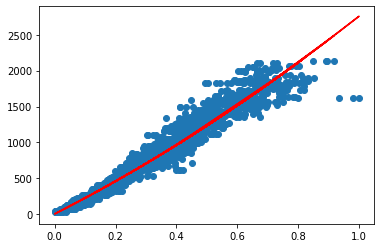

In [30]:
# 일령 - 체중
m1 = polyFeatures[:,0]
n= 5.2594+ 2154.6709*m1 + 597.038*m1*m1 

plt.scatter(x= polyFeatures[:,0], y=features_y)
plt.plot(m1,n, color='red')
plt.savefig("C:/Users/MSDL-DESK-02/Desktop/fig/area_weight.png")
plt.show()